# Pedro - Short Queeze Predictor
---

### 1. Libraries Import

In [125]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

import xgboost as xgb
import tensorflow as tf
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder

### 2. Data Import

In [126]:
# Read the ShortSqueezeData.csv file into a Pandas DataFrame
merged_df = pd.read_csv(
    Path("Resources/ShortSqueezeData.csv"),
    parse_dates=True,
    infer_datetime_format=True
)

### 3. Data Cleaning

In [127]:
merged_df.drop_duplicates(subset=['Symbol', 'Short % of Float'], keep='first', inplace=True)

In [128]:
# Review the DataFrame
merged_df

,Date,Symbol,Short % of Float,Total Amount,Market Cap,% Insider Ownership,% Institutional Ownership,Relation,Sector,Return (5 Days),Return (7 Days),Return (15 Days),Return (30 Days),Short Squeeze
0,2022-08-19,ABCL,10.26,2292460.00,3.210520e+09,28.82,41.01,Large Shareholder,Healthcare,6.47,-7.08,-2.10,-13.55,0
1,2021-07-19,AFIB,12.34,9999990.00,4.334698e+08,2.26,88.83,"Large Shareholder, Director",Healthcare,24.72,11.05,15.53,-0.30,1
2,2022-05-24,AHCO,12.52,1727230.00,2.269454e+09,27.42,61.25,Director,Healthcare,3.69,4.78,-0.58,11.01,0
3,2022-06-13,AHCO,10.25,1722010.00,2.490455e+09,27.42,61.25,Director,Healthcare,0.35,4.25,7.33,22.40,0
7,2022-06-17,AMEH,12.69,9250000.00,2.216500e+09,32.52,31.35,Large Shareholder,Healthcare,15.43,13.62,28.74,57.47,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,2023-01-23,TREE,10.05,1293440.96,4.272510e+08,15.11,83.84,"Large Shareholder, Officer, Director",Financial Services,18.86,23.01,35.24,2.26,1
222,2022-03-04,TRIP,13.53,1036617.76,2.955059e+09,19.91,78.11,Director,Consumer Cyclical,11.31,9.96,21.59,24.33,1
223,2022-06-10,TUP,11.57,1031900.00,3.000068e+08,6.26,91.04,"Officer, Director",Consumer Cyclical,3.06,11.61,8.06,12.26,1
224,2022-05-12,UWMC,24.79,1010056.36,3.990357e+08,0.20,26.88,"Officer, Director",Financial Services,8.38,7.03,10.54,3.51,0


In [129]:
# Short Squeeze vs. Non Short Squeeze Counts in DataFrame
short_squeeze_count = merged_df.loc[merged_df['Short Squeeze'] == 1, 'Short Squeeze'].count()
no_short_squeeze_count = merged_df.loc[merged_df['Short Squeeze'] == 0, 'Short Squeeze'].count()

print("Short Squeeze:", short_squeeze_count)
print("Non Short Squeeze:", no_short_squeeze_count)

Short Squeeze: 43
Non Short Squeeze: 72


### 4. Data Visualization

<Figure size 1000x600 with 0 Axes>

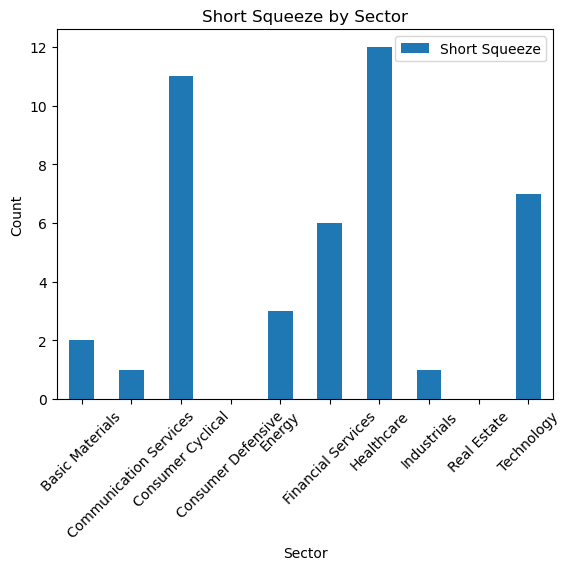

In [130]:
# Visualization by Sector
plt.figure(figsize=(10, 6))
grouped_df = merged_df.groupby('Sector')['Short Squeeze'].sum().reset_index()
grouped_df.plot(x='Sector', y='Short Squeeze', kind='bar')
plt.title('Short Squeeze by Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x600 with 0 Axes>

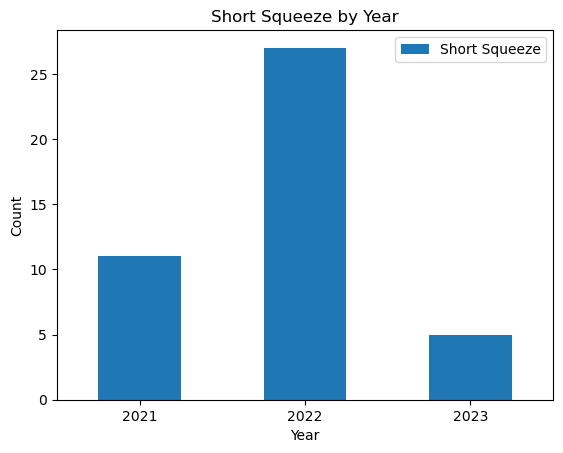

In [131]:
# Visualization by Year
merged_df['Year'] = pd.to_datetime(merged_df['Date']).dt.year
plt.figure(figsize=(8, 6))
grouped_df = merged_df.groupby('Year')['Short Squeeze'].sum().reset_index()
grouped_df.plot(x='Year', y='Short Squeeze', kind='bar')
plt.title('Short Squeeze by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### 5. One Hot Encoding

In [132]:
def one_hot_encode(df):
    encoder = OneHotEncoder(sparse=False)
    categorical_variables = ['Sector', 'Relation']
    encoded_data = encoder.fit_transform(df[categorical_variables])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_variables))
    encoded_df.index = df.index 
    numerical_df = df.drop(columns=categorical_variables, axis=1)
    return pd.concat([numerical_df, encoded_df], axis=1)

In [133]:
# One hot encode the data
merged_df = one_hot_encode(merged_df)

### 6. Train-Test Split

In [134]:
# Drop the 'Short Squeeze', 'Symbol' and 'Date' columns for features
X = merged_df.drop(columns=['Short Squeeze', 'Symbol', 'Date', 'Return (5 Days)', 'Return (7 Days)', 'Return (15 Days)', 'Return (30 Days)'])
y = merged_df['Short Squeeze']

# split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7. Data Normalization

In [135]:
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 8. Class Balancing

#### Synthetic Minority Over-sampling Technique (SMOTE)

In [136]:
# Create a SMOTE object
smote = SMOTE()

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Print the class counts
print(pd.Series(y_train_resampled).value_counts())

0    55
1    55
Name: Short Squeeze, dtype: int64


In [137]:
# Function for training and evaluating a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Check if the model is a Neural Network model
    if isinstance(model, Sequential):
        # Reshape target arrays
        y_train = np.array(y_train).reshape(-1, 1)
        y_test = np.array(y_test).reshape(-1, 1)

        # Train the model
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
        model_name = "\033[1mNeural Network\033[0m"
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_name = "\033[1m" + type(model).__name__ + "\033[0m"  # gets the name of the model and adds bold formatting
        
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

### 9. Model Training

In [138]:
# Neural Network model
model_nn = Sequential()
model_nn.add(Dense(32, input_dim=X_train_resampled.shape[1], activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))  
model_nn.compile(loss='binary_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

models = [
    GradientBoostingClassifier(random_state=42),
    SVC(random_state=42),
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=0),
    xgb.XGBClassifier(),
    model_nn
]

In [139]:
for model in models:
    train_and_evaluate_model(model, X_train_resampled, y_train_resampled, X_test_scaled, y_test)

Classification Report for GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.33      0.50      0.40         6

    accuracy                           0.61        23
   macro avg       0.56      0.57      0.55        23
weighted avg       0.67      0.61      0.63        23

Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.82      0.53      0.64        17
           1       0.33      0.67      0.44         6

    accuracy                           0.57        23
   macro avg       0.58      0.60      0.54        23
weighted avg       0.69      0.57      0.59        23

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        17
           1       0.42      0.83      0.56         6

    accuracy                           0.65    